In [1]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

In [3]:
# Đường dẫn đến dữ liệu
data_dir = './chest_xray/'
labels = ['NORMAL', 'PNEUMONIA']
img_size = 150

In [4]:
# Hàm tiền xử lý dữ liệu
def load_data(directory):
    data = []
    for label in labels:
        path = os.path.join(directory, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_img = cv2.resize(img_array, (img_size, img_size))
                data.append([resized_img, class_num])
            except Exception as e:
                print(f'Lỗi: {e}')
    return np.array(data, dtype=object)

In [5]:
# Tải dữ liệu
train_data = load_data(os.path.join(data_dir, 'train'))
val_data = load_data(os.path.join(data_dir, 'val'))
test_data = load_data(os.path.join(data_dir, 'test'))


In [6]:
# Phân tách features và labels
x_train, y_train = zip(*train_data)
x_val, y_val = zip(*val_data)
x_test, y_test = zip(*test_data)

x_train = np.array(x_train) / 255.0
x_val = np.array(x_val) / 255.0
x_test = np.array(x_test) / 255.0

x_train = x_train.reshape(-1, img_size, img_size, 1)
x_val = x_val.reshape(-1, img_size, img_size, 1)
x_test = x_test.reshape(-1, img_size, img_size, 1)

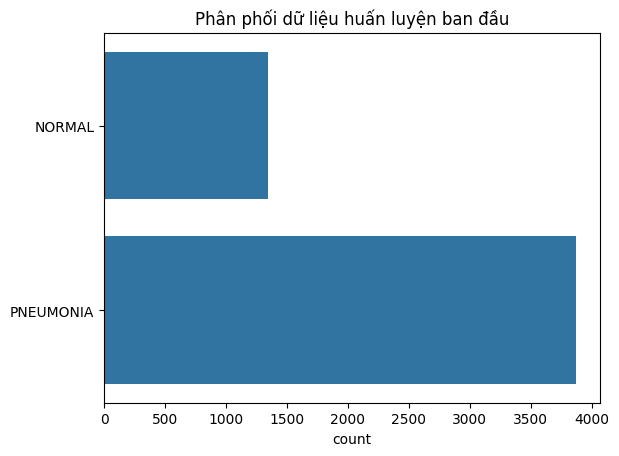

In [7]:
# Hiển thị phân phối dữ liệu trước khi cân bằng
sns.countplot([labels[i] for i in y_train])
plt.title('Phân phối dữ liệu huấn luyện ban đầu')
plt.show()

In [8]:
# Cân bằng dữ liệu bằng nhân bản dữ liệu thiểu số
count_classes = Counter(y_train)
max_count = max(count_classes.values())

x_train_balanced = []
y_train_balanced = []

for class_label in count_classes:
    class_indices = [i for i, label in enumerate(y_train) if label == class_label]
    num_to_add = max_count - count_classes[class_label]
    x_train_balanced.extend(x_train[class_indices])
    y_train_balanced.extend([class_label] * len(class_indices))
    
    extra_indices = np.random.choice(class_indices, num_to_add, replace=True)
    x_train_balanced.extend(x_train[extra_indices])
    y_train_balanced.extend([class_label] * num_to_add)

x_train_balanced = np.array(x_train_balanced)
y_train_balanced = np.array(y_train_balanced)


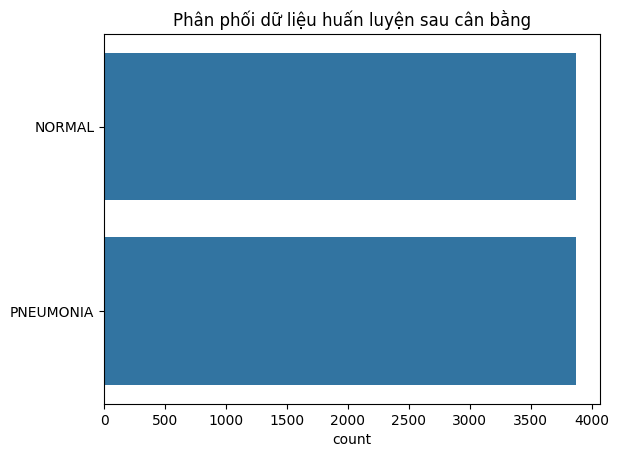

In [9]:
# Hiển thị phân phối dữ liệu sau khi cân bằng
sns.countplot([labels[i] for i in y_train_balanced])
plt.title('Phân phối dữ liệu huấn luyện sau cân bằng')
plt.show()

In [10]:
# Khởi tạo mô hình CNN cải tiến
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1)),
    BatchNormalization(),
    MaxPool2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.4),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPool2D((2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 148, 148, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 72, 72, 64)        256       
 chNormalization)                                                
                                                        

In [12]:
# Huấn luyện mô hình
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# Chuyển đổi y_train_balanced sang NumPy array đúng định dạng
y_train_balanced = np.array(y_train_balanced, dtype=np.int32)
y_val = np.array(y_val, dtype=np.float32)

history = model.fit(x_train_balanced, y_train_balanced,
                    validation_data=(x_val, y_val),
                    epochs=25, batch_size=32,
                    callbacks=[early_stop, reduce_lr])

Epoch 1/25
243/243 [==============================] - 180s 739ms/step - loss: 0.0086 - accuracy: 0.9973 - val_loss: 0.0377 - val_accuracy: 1.0000 - lr: 2.0000e-05
Epoch 2/25
243/243 [==============================] - 175s 722ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0521 - val_accuracy: 0.9375 - lr: 2.0000e-05
Epoch 3/25
243/243 [==============================] - 163s 670ms/step - loss: 0.0060 - accuracy: 0.9975 - val_loss: 0.0469 - val_accuracy: 1.0000 - lr: 2.0000e-05
Epoch 4/25
243/243 [==============================] - 164s 673ms/step - loss: 0.0054 - accuracy: 0.9978 - val_loss: 0.0454 - val_accuracy: 1.0000 - lr: 2.0000e-05
Epoch 5/25
243/243 [==============================] - 164s 673ms/step - loss: 0.0070 - accuracy: 0.9975 - val_loss: 0.0377 - val_accuracy: 1.0000 - lr: 1.0000e-05
Epoch 6/25
243/243 [==============================] - 164s 676ms/step - loss: 0.0057 - accuracy: 0.9985 - val_loss: 0.0400 - val_accuracy: 1.0000 - lr: 1.0000e-05


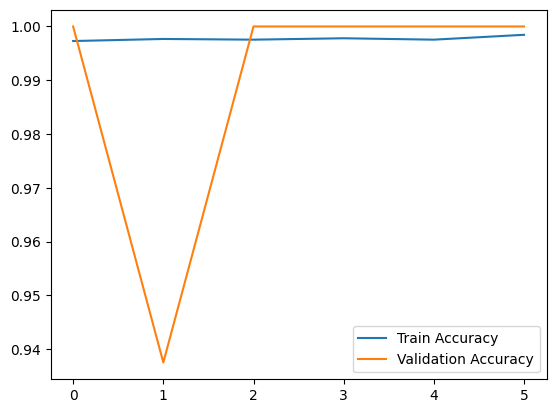

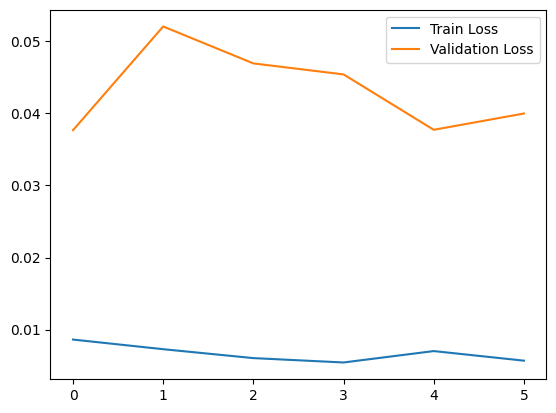

In [13]:
# Đánh giá mô hình
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [14]:
# Dự đoán và đánh giá trên tập kiểm tra
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=labels))

20/20 [==============================] - 3s 120ms/step
[[116 118]
 [  5 385]]
              precision    recall  f1-score   support

      NORMAL       0.96      0.50      0.65       234
   PNEUMONIA       0.77      0.99      0.86       390

    accuracy                           0.80       624
   macro avg       0.86      0.74      0.76       624
weighted avg       0.84      0.80      0.78       624



In [15]:
# Lưu mô hình
model.save('model_cnn.h5')

c:\Users\ACER\anaconda3\envs\tensor\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
